<a href="https://colab.research.google.com/github/ryannemilligan/TENNIQ/blob/main/TennIQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TennisIQ: Real-Time Injury Prevention for Tennis Players

TennisIQ is a real-world injury prevention system designed to monitor wrist motion in tennis players and provide actionable insights that reduce the risk of tennis elbow and other overuse injuries.

The system aims to use wearable inertial sensors to continuously track wrist angular velocity and acceleration during tennis strokes, identify risky movement patterns, and deliver immediate feedback to players and coaches to improve technique and prevent injury.

Currently, access to large-scale tennis wearable sensor datasets is limited. This notebook begins by building foundational data processing and machine learning pipelines using carefully designed synthetic data to simulate wrist motion during tennis strokes. These pipelines are intended as prototypes for future integration with real sensor data collected from consumer wearables or dedicated devices.

The ultimate vision of TennisIQ is to become a practical, scalable solution that integrates seamlessly with wearable sensor hardware, empowering tennis players at all levels to train smarter, play safer, and extend their careers.

---

## What I Used

- **Python** for data processing and model development  
- **NumPy & Pandas** for numerical operations and data manipulation  
- **Matplotlib & Seaborn** for data visualization  
- **Scikit-learn** for machine learning model building  
- **Synthetic data generation** to simulate realistic wrist motion IMU signals  
- Future integration with wearable sensor APIs and mobile applications for real-time monitoring


 Step 1: Create the Simulated Data (Temporary)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# Simulate 60 seconds of data at 50 Hz
fs = 50  # sampling frequency (Hz)
duration = 60
samples = fs * duration
time = np.linspace(0, duration, samples)

# Simulate wrist angular velocity
forehand = 30 * np.sin(2 * np.pi * 1 * time) * (np.mod(time, 2) < 0.5)
backhand = 25 * np.sin(2 * np.pi * 0.8 * time) * (np.mod(time, 3) < 0.6)

# NEW: Add bursts of high-intensity (high-risk) motion randomly
high_risk_bursts = np.zeros(samples)
burst_indices = np.random.choice(range(0, samples), size=8, replace=False)
for idx in burst_indices:
    end = min(idx + fs * 2, samples)  # 2-second burst
    high_risk_bursts[idx:end] = 1

# Simulate increased velocity during bursts
high_intensity_motion = 50 * high_risk_bursts * np.sin(2 * np.pi * 2 * time)
angular_velocity = forehand + backhand + high_intensity_motion + np.random.normal(0, 3, samples)

# Simulate acceleration with added burst intensity
acceleration = 5 * np.abs(np.sin(2 * np.pi * 1 * time)) + 10 * high_risk_bursts + np.random.normal(0, 0.5, samples)

# Stroke type: 0 = none, 1 = forehand, 2 = backhand
stroke_type = np.zeros(samples)
stroke_type[(np.mod(time, 2) < 0.5)] = 1
stroke_type[(np.mod(time, 3) < 0.6)] = 2

# High-risk frame if angular velocity exceeds 40 deg/s
intensity = (np.abs(angular_velocity) > 40).astype(int)

# DataFrame
df = pd.DataFrame({
    'time_sec': time,
    'angular_velocity': angular_velocity,
    'acceleration': acceleration,
    'stroke_type': stroke_type,
    'intensity': intensity
})


Step 2: Plot the Data

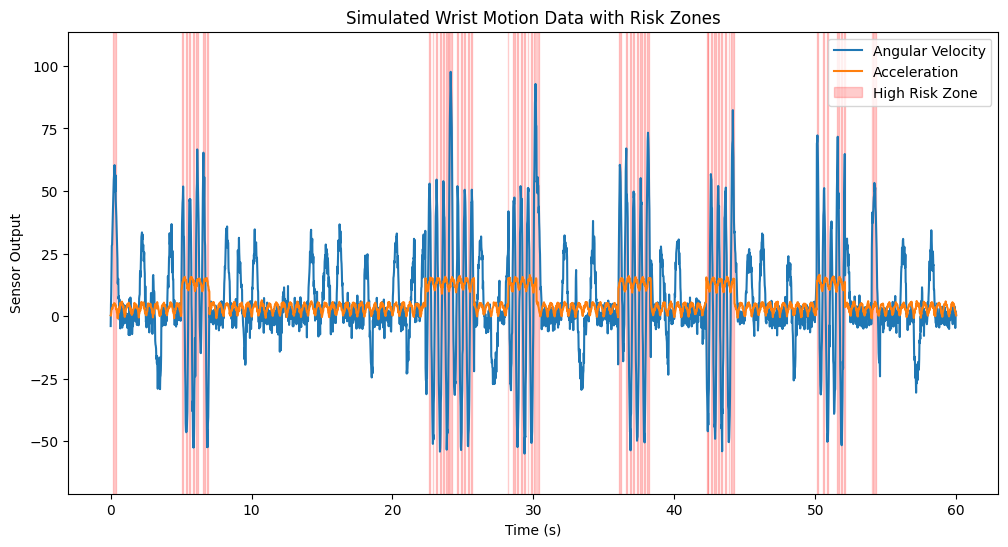

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['time_sec'], df['angular_velocity'], label='Angular Velocity')
plt.plot(df['time_sec'], df['acceleration'], label='Acceleration')
plt.fill_between(df['time_sec'], 0, 1, where=df['intensity'] == 1, color='red', alpha=0.2, transform=plt.gca().get_xaxis_transform(), label='High Risk Zone')
plt.xlabel("Time (s)")
plt.ylabel("Sensor Output")
plt.legend()
plt.title("Simulated Wrist Motion Data with Risk Zones")
plt.show()


Step 3: Feature Extraction

In [ ]:
# Windowing settings
window_size = 5 * fs  # 5 seconds
step_size = window_size  # non-overlapping windows

features = []

for start in range(0, len(df), step_size):
    end = start + window_size
    if end > len(df):
        break  # skip incomplete window

    window = df.iloc[start:end]

    feat = {
        'start_time': window['time_sec'].iloc[0],
        'end_time': window['time_sec'].iloc[-1],
        'mean_angular_velocity': window['angular_velocity'].mean(),
        'max_angular_velocity': window['angular_velocity'].max(),
        'mean_acceleration': window['acceleration'].mean(),
        'stroke_count': (window['stroke_type'] > 0).sum(),
        'high_risk_ratio': window['intensity'].mean(),  # percent of time flagged high risk
    }

    features.append(feat)

features_df = pd.DataFrame(features)
features_df.head()


,start_time,end_time,mean_angular_velocity,max_angular_velocity,mean_acceleration,stroke_count,high_risk_ratio
0,0.000000,4.981661,6.430499,60.247708,3.122183,110,0.048
1,5.001667,9.983328,5.328209,66.620137,7.233508,85,0.164
2,10.003334,14.984995,4.172360,34.688384,3.197647,80,0.000
3,15.005002,19.986662,4.581782,36.696452,3.146055,85,0.000
4,20.006669,24.988329,5.923164,97.626597,8.537402,110,0.200


Step 4: Build a Simple Risk Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 👀 Optionally check current class balance
print("Risk label distribution before threshold change:")
# Apply the threshold and count the values
print(features_df['high_risk_ratio'].apply(lambda x: int(x > 0.5)).value_counts())


# ✅ Adjust threshold to label more windows as high risk
# Changed threshold to 0.05 to increase the number of positive samples
features_df['risk_label'] = (features_df['high_risk_ratio'] > 0.05).astype(int)


# 📊 Check updated label balance
print("\nRisk label distribution after threshold change:")
print(features_df['risk_label'].value_counts())

# 🎯 Define features and labels
X = features_df[['mean_angular_velocity', 'max_angular_velocity', 'mean_acceleration', 'stroke_count']]
y = features_df['risk_label']

# 🔀 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🤖 Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# 📈 Make predictions
y_pred = model.predict(X_test)

# 🧾 Show performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Risk label distribution before threshold change:
high_risk_ratio
0    12
Name: count, dtype: int64

Risk label distribution after threshold change:
risk_label
1    7
0    5
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3

